# DA10 Preprocess
06/25/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis/')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA10'
subj_format = ['nlx']
subj_site = ['UCD']


## Load raw nlx data 


In [6]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'
seeg_names = None
resp_names = None
ekg_names = None
eeg_names = None

In [11]:
### removing extraneous numbering from channel names 

# per Shawn, MSSM data seems to sometime have a "_0000.ncs" to "_9999.ncs" appended to the end of real data
pattern = re.compile(r"_\d{4}\.ncs")  # regex pattern to match "_0000.ncs" to "_9999.ncs"
ncs_files = [x for x in glob(f'{load_path}/*.ncs') if re.search(pattern, x)]
# just in case this changes in the future: 
if len(ncs_files) == 0: 
    ncs_files = glob(f'{load_path}/*.ncs')
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','') for x in glob(f'{load_path}/[R,L]*.ncs')]
else:
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','').split('_')[0] for x in glob(f'{load_path}/[R,L]*.ncs') if re.search(pattern, x)]

In [12]:
seeg_names = [x.lower() for x in seeg_names]
sEEG_mapping_dict = {f'{x}':'seeg' for x in seeg_names}

In [25]:
sEEG_mapping_dict

{'ltt1': 'seeg',
 'lhh5': 'seeg',
 'lhh4': 'seeg',
 'lad1': 'seeg',
 'lhb9': 'seeg',
 'lhb8': 'seeg',
 'ltpo1': 'seeg',
 'lof6': 'seeg',
 'lof7': 'seeg',
 'lhb3': 'seeg',
 'lhb2': 'seeg',
 'lhh2': 'seeg',
 'lhh3': 'seeg',
 'lad6': 'seeg',
 'lad7': 'seeg',
 'lhh8': 'seeg',
 'lhh9': 'seeg',
 'ltpo7': 'seeg',
 'ltpo6': 'seeg',
 'lof1': 'seeg',
 'lhb4': 'seeg',
 'lhb5': 'seeg',
 'ltt7': 'seeg',
 'ltt6': 'seeg',
 'ltpo3': 'seeg',
 'ltpo2': 'seeg',
 'lad8': 'seeg',
 'lad9': 'seeg',
 'lof5': 'seeg',
 'lof4': 'seeg',
 'lhb1': 'seeg',
 'lad2': 'seeg',
 'lad3': 'seeg',
 'lhh6': 'seeg',
 'lhh7': 'seeg',
 'ltpo8': 'seeg',
 'ltt8': 'seeg',
 'ltt3': 'seeg',
 'ltt2': 'seeg',
 'ltt4': 'seeg',
 'ltt5': 'seeg',
 'ltpo4': 'seeg',
 'ltpo5': 'seeg',
 'lof2': 'seeg',
 'lof3': 'seeg',
 'lhb7': 'seeg',
 'lhb6': 'seeg',
 'lof8': 'seeg',
 'lof9': 'seeg',
 'lad5': 'seeg',
 'lad4': 'seeg',
 'lhh1': 'seeg'}

In [14]:
### empty vecs to load data into 

signals = [] #data
srs = [] #sampling rate
ch_name = [] #channel name
ch_type = [] #channel type (seeg, eeg etc.)

In [15]:
for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    try:
        fdata = nlx_utils.load_ncs(chan_path)
    except IndexError: 
        print(f'No data in channel {chan_name}')
        continue
    if eeg_names:
        if chan_name.lower() in eeg_names:
            ch_type.append('eeg')
    if resp_names:
        if chan_name.lower() in resp_names:
            ch_type.append('bio')
    if ekg_names:
        if chan_name.lower() in ekg_names: 
            ch_type.append('ecg') 
    if seeg_names: 
        if chan_name.lower() in seeg_names:
            ch_type.append('seeg')  
        elif chan_name.lower()[0] == 'u':
            # microwire data
            ch_type.append('seeg')  
    signals.append(fdata['data'])
    srs.append(fdata['sampling_rate'])
    ch_name.append(chan_name)
    if len(ch_type) < len(ch_name):
        ch_type.append('misc')
        print(f'Unidentified data type in {chan_name}')

Unidentified data type in Photodiode


In [16]:
fdata['data'].shape

(12682240,)

In [17]:
srs

[4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000]

In [20]:
target_sr = 500 #downsampling to 500 to be consistent with other data
mne_data_resampled = []

In [21]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr, [x for ix, x in enumerate(ch_type) if ix in ch_ix])
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:   17.6s finished


In [22]:
info.ch_names

['LTT1',
 'LHH5',
 'LHH4',
 'LAD1',
 'LHB9',
 'LHB8',
 'LTPO1',
 'LOF6',
 'LOF7',
 'LHB3',
 'LHB2',
 'LHH2',
 'LHH3',
 'LAD6',
 'LAD7',
 'LHH8',
 'LHH9',
 'LTPO7',
 'LTPO6',
 'LOF1',
 'LHB4',
 'LHB5',
 'LTT7',
 'LTT6',
 'Photodiode',
 'LTPO3',
 'LTPO2',
 'LAD8',
 'LAD9',
 'LOF5',
 'LOF4',
 'LHB1',
 'LAD2',
 'LAD3',
 'LHH6',
 'LHH7',
 'LTPO8',
 'LTT8',
 'LTT3',
 'LTT2',
 'LTT4',
 'LTT5',
 'LTPO4',
 'LTPO5',
 'LOF2',
 'LOF3',
 'LHB7',
 'LHB6',
 'LOF8',
 'LOF9',
 'LAD5',
 'LAD4',
 'LHH1']

In [23]:
### make sure timing is aligned post resampling 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

try loading data into memory

In [24]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
mne_data

<RawArray | 53 x 1585280 (3170.6 s), ~641.1 MB, data loaded>

## Examine photodiode

In [26]:
#make mne_names lowercase 
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict) 

<RawArray | 53 x 1585280 (3170.6 s), ~641.1 MB, data loaded>

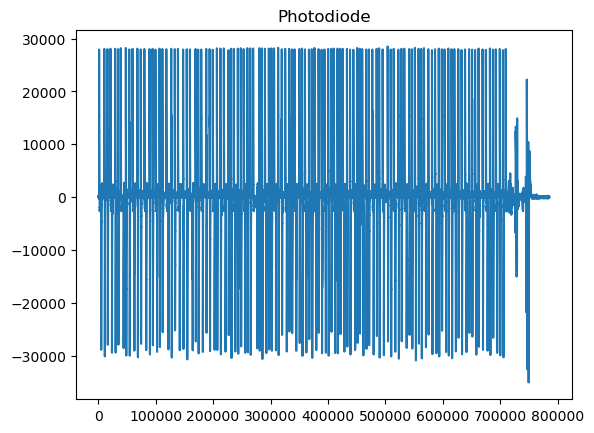

In [31]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index('photodiode')
plt.plot(mne_data._data[trig_ix, 800000:8000000]) #hopefully 
plt.title("Photodiode")
plt.show()

In [32]:
mne_data.save(f'{neural_dir}/DA10/photodiode.fif', picks='photodiode', overwrite=True)

## Notch Filter Line Noise

In [33]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.9s finished


<RawArray | 53 x 1585280 (3170.6 s), ~641.1 MB, data loaded>

## Anat Recon Info


In [57]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LAD1,rHipp_L,-14.399994,7.691510,-14.025760,-14.342856,-5.763441,-22.991499,Gray,Left PHG parahippocampal gyrus,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left parahippocampal gyrus A,NaN
1,LAD2,rHipp_L,-19.599993,7.291924,-14.025760,-20.094629,-6.129953,-22.869272,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala inferior,NaN
2,LAD3,rHipp_L,-24.799993,6.892338,-13.626463,-25.843869,-6.282030,-22.239514,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala inferior,NaN
3,LAD4,lAmyg_L,-29.599993,6.892338,-13.626463,-31.162715,-6.120036,-22.229235,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Amyg,Left amygdala inferior,NaN
4,LAD5,Unknown,-34.799992,6.492752,-13.227165,-36.913993,-6.484951,-21.801391,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
5,LAD6,Unknown,-39.599992,6.093167,-13.227165,-42.078518,-7.123732,-21.935039,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
6,LAD7,aSTS_L,-44.799992,6.093167,-13.227165,-47.687519,-7.375745,-22.114078,White,Left Cerebral White Matter,Unknown,L Middle Temporal Gyrus,L MTG,Left superior middle temporal gyrus A,WM
7,LAD8,aSTS_L,-49.599992,5.693581,-12.827868,-52.874503,-7.931650,-21.592201,White,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left superior middle temporal gyrus A,WM
8,LAD9,A21r_L,-54.799991,5.693581,-12.827868,-58.525474,-8.184515,-21.581147,White,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left inferior middle temporal gyrus A,NaN
9,LHB1,cHipp_L,-26.399993,-14.685300,-10.432084,-26.654716,-29.075918,-14.281852,Gray,Left Hippocampus,Subiculum,L ParaHippocampal Gyrus,L Hipp,Left hippocampus body,NaN


In [35]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['photodiode']


In [36]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)




In [37]:
unmatched_seeg

[]

In [38]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right' 'sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 52 left & 0 rightsEEG electrodes
We have a total of 52 sEEG electrodes


In [39]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in seeg_names}
trig_mapping_dict = {'photodiode':'stim'} #'stim test1-ref' 'Stim TEST1-REF' stim stands for stimulus 
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawArray | 53 x 1585280 (3170.6 s), ~641.1 MB, data loaded>

In [40]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawArray | 53 x 1585280 (3170.6 s), ~641.1 MB, data loaded>

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [41]:
bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
mne_data.info['bads'] = bads

In [42]:
bads #MUST verify this manually - usually incorrect

['lhb3', 'lof1', 'ltt3', 'ltt4', 'ltt5', 'ltt6']

In [43]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [44]:
probe_names

array(['lad', 'lhb', 'lhh', 'lof', 'ltpo', 'ltt'], dtype='<U4')

In [45]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [46]:
probe_ch_counts

{'lad': 9, 'lhb': 9, 'lhh': 9, 'lof': 9, 'ltpo': 8, 'ltt': 8}

<IPython.core.display.Javascript object>


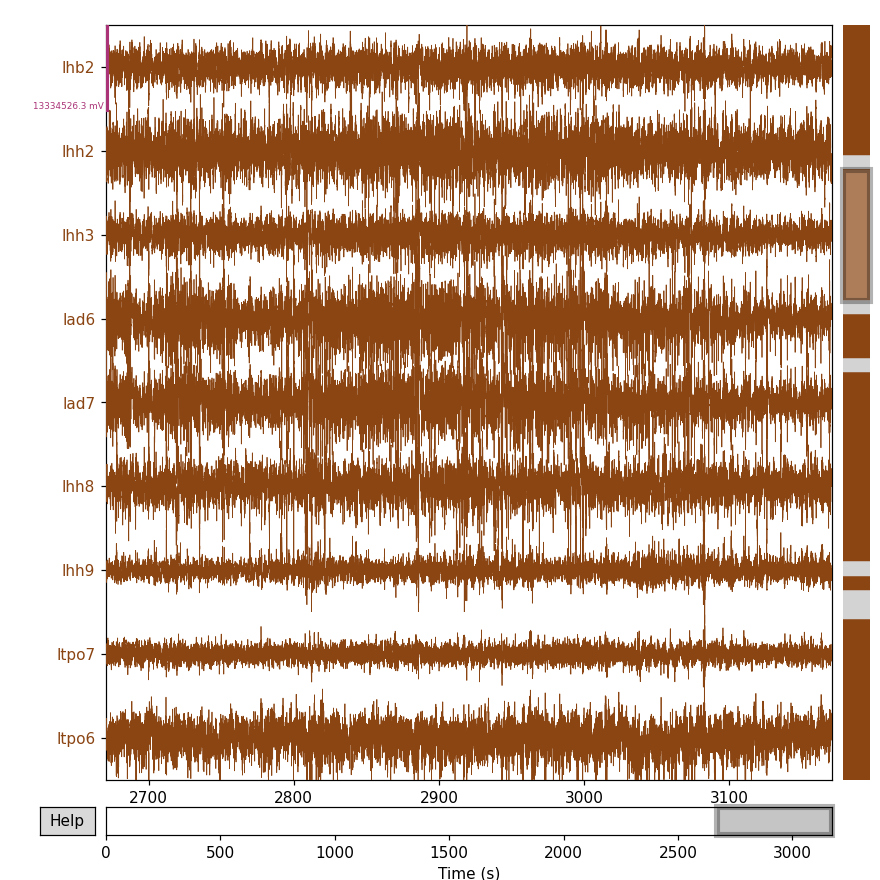

<IPython.core.display.Javascript object>


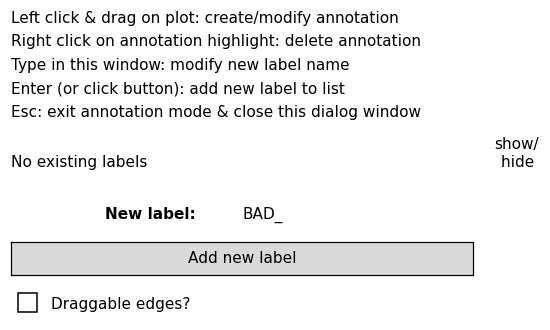

In [47]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=9, scalings=mne_data._data.max()/5)
fig.fake_keypress('a')

In [73]:
mne_data.info['bads']

['ltt3', 'ltt4', 'ltt5', 'ltt6', 'ltt2', 'ltt1']

In [48]:
#set bad channel info 
bad_ch = ['ltt3', 'ltt4', 'ltt5', 'ltt6', 'ltt2', 'ltt1']

In [49]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = bad_ch

In [50]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 6 items (ltt3, ltt4, ltt5, ltt6, ltt2, ltt1)
 ch_names: ltt1, lhh5, lhh4, lad1, lhb9, lhb8, ltpo1, lof6, lof7, lhb3, ...
 chs: 52 sEEG
 custom_ref_applied: False
 dig: 52 items (52 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 52
 projs: []
 sfreq: 500.0 Hz
>

In [51]:
mne_data.info['bads'] #more sanity checking

['ltt3', 'ltt4', 'ltt5', 'ltt6', 'ltt2', 'ltt1']

### Rereference data to wm electrodes

In [53]:
unmatched_seeg = [] 

In [58]:
anat_file

'/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/DA10_labels.csv'

In [62]:


def bipolar_ref(elec_path, bad_channels, unmatched_seeg=None, site=None):
    """
    Return the cathode list and anode list for mne to use for bipolar referencing.

    Parameters
    ----------
    elec_data : pandas df 
        dataframe containing the electrode localization information
    bad_channels : list 
        bad channels 
    unmatched_seeg : list 
        list of channels that were not in the edf file 
    site : str
        hospital where the recording took place 

    Returns
    -------
    anode_list : list 
        list of channels to subtract from
    cathode_list : list 
        list of channels to subtract
    """

    elec_data = lfp_preprocess_utils.load_elec(elec_path)
    elec_data['bundle'] = np.nan
    elec_data['bundle'] = elec_data.apply(lambda x: ''.join(i for i in x.label if not i.isdigit()), axis=1)

    drop_from_locs = []
    for ind, data in elec_data['label'].str.lower().items(): 
        if data in unmatched_seeg:
            drop_from_locs.append(ind)
        elif data[0] == 'u':
            drop_from_locs.append(ind)

    elec_data = elec_data.drop(index=drop_from_locs).reset_index(drop=True)

    # get the white matter electrodes and make sure they are note in the bad channel list
    wm_elec_ix_manual = [] 
    wm_elec_ix_auto = []
    if 'Manual Examination' in elec_data.keys():
        wm_elec_ix_manual = wm_elec_ix_manual + [ind for ind, data in elec_data['Manual Examination'].str.lower().items() if data=='wm' and elec_data['label'].str.lower()[ind] not in bad_channels]
        oob_elec_ix = [ind for ind, data in elec_data['Manual Examination'].str.lower().items() if data=='oob']
    else: # this means we haven't doublechecked the electrode locations manually but trust the automatic locations
        wm_elec_ix_auto = wm_elec_ix_auto + [ind for ind, data in elec_data['gm'].str.lower().items() if data=='white' and elec_data['label'].str.lower()[ind] not in bad_channels]
        oob_elec_ix = [ind for ind, data in elec_data['gm'].str.lower().items() if data=='unknown']

    wm_channels = elec_data['label'].str.lower()[wm_elec_ix_manual + wm_elec_ix_auto].tolist()
    oob_channels = elec_data['label'].str.lower()[oob_elec_ix].tolist()

    # helper function to perform sort for bipolar electrodes:
    def sort_strings(strings):
        # Create a regular expression pattern to extract the number at the end of each string
        pattern = re.compile(r'\d+$')

        # Sort the strings using a custom key function
        sorted_strings = sorted(strings, key=lambda x: int(pattern.search(x).group()), reverse=False)

        return sorted_strings

    cathode_list = [] 
    anode_list = [] 
    drop_wm_channels = [] 

    if site=='MSSM':

        for bundle in elec_data.bundle.unique():
            if bundle[0] == 'u':
                print('this is a microwire, pass')
                continue         
            # Isolate the electrodes in each bundle 
            bundle_df = elec_data[elec_data.bundle==bundle].sort_values(by='z', ignore_index=True)
            all_elecs = bundle_df.label.str.lower().tolist()
            # Sort them by number 
            all_elecs = sort_strings(all_elecs)
            # make sure these are not bad channels 
            all_elecs = [x for x in all_elecs if x not in bad_channels]
            # Set the cathodes and anodes 
            cath = all_elecs[1:]
            an = all_elecs[:-1]
            # I need to make sure I drop any channels where both electrodes are in the wm
            if cath in wm_channels and an in wm_channels:
                drop_wm_channels.append(cath)
                drop_wm_channels.append(an)
                continue
            # I need to make sure I drop any channels where either electrode is out of the brain
            elif cath in oob_channels or an in oob_channels:
                continue
            else:
                cathode_list = cathode_list + cath
                anode_list = anode_list + an

    # elif site=='UI':

    #     for bundle in elec_data.bundle.unique():
    #         # Isolate the electrodes in each bundle 
    #         bundle_df = elec_data[elec_data.bundle==bundle].sort_values(by='contact', ignore_index=True)
    #         all_elecs = bundle_df.Channel.tolist()
    #         # make sure these are not bad channels 
    #         all_elecs = [x for x in all_elecs if x not in bad_channels]
    #         # Set the cathodes and anodes 
    #         cath = all_elecs[1:]
    #         an = all_elecs[:-1]
    #         cathode_list = cathode_list + cath
    #         anode_list = anode_list + an

    return anode_list, cathode_list, drop_wm_channels, oob_channels



In [63]:
anode_list, cathode_list, drop_wm_channels, oob_channels = bipolar_ref(elec_path=anat_file, 
                                       bad_channels=mne_data.info['bads'], 
                                       unmatched_seeg=unmatched_seeg,
                                       site='MSSM')

In [67]:
oob_channels

['ltpo8']

In [79]:
# anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
#                                                                                 elec_path=anat_file, 
#                                                                                 unmatched_seeg = unmatched_seeg,
#                                                                                 bad_channels=mne_data.info['bads'],
#                                                                                       site = 'MSSM')

In [81]:
oob_channels

['ltpo8']

In [68]:
#add oob channels to bad channels list
bad_ch = bad_ch + oob_channels
bad_ch = list(np.unique(bad_ch))
mne_data.info['bads'] = bad_ch

In [69]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['ltpo8', 'ltt1', 'ltt2', 'ltt3', 'ltt4', 'ltt5', 'ltt6']

In [70]:
mne_data.save(f'{neural_dir}/DA10/lfp_data.fif')

FileExistsError: Destination file exists. Please use option "overwrite=True" to force overwriting.

In [71]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True) #method = 'bipolar'

In [72]:
mne_data_reref

<RawArray | 46 x 1585280 (3170.6 s), ~556.4 MB, data loaded>

In [73]:
mne_data_reref.save(f'{neural_dir}/DA10/bipolar_ref_ieeg.fif')

<IPython.core.display.Javascript object>


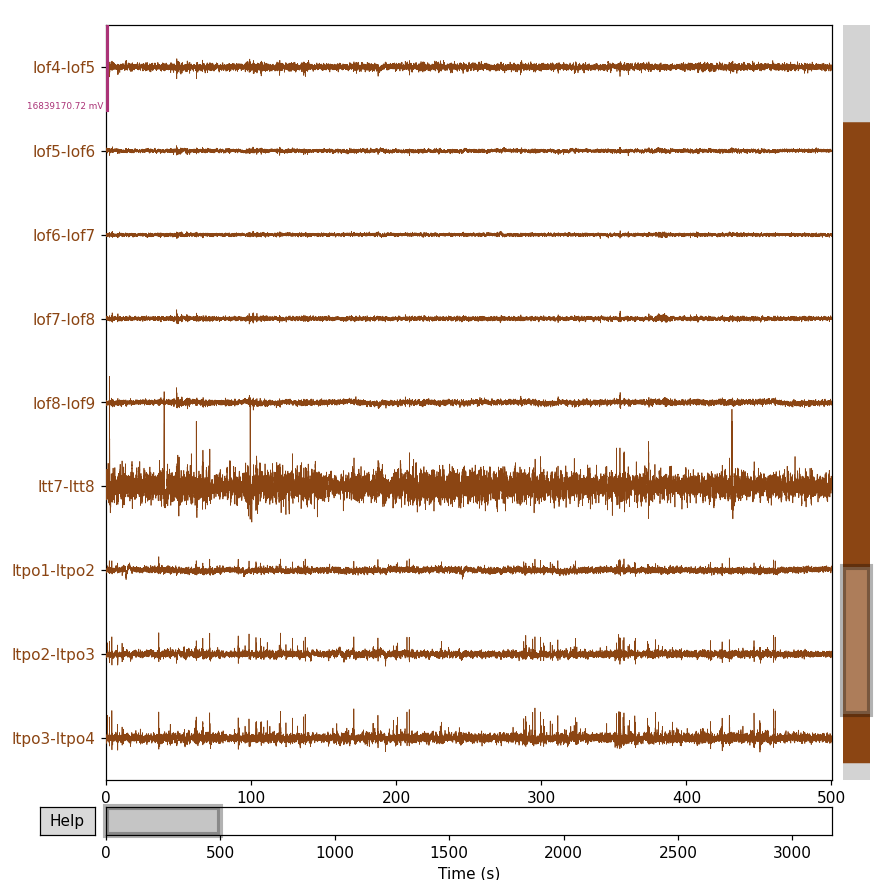

<IPython.core.display.Javascript object>


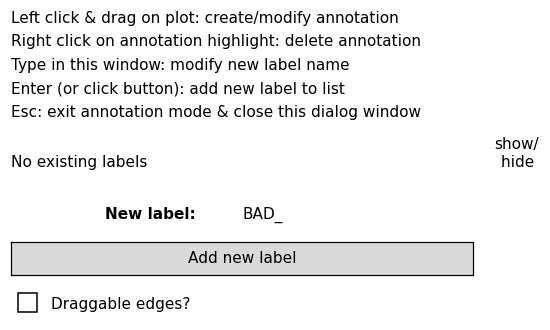

In [74]:
%matplotlib notebook 
fig = mne_data_reref.plot(start=0, duration=500, n_channels=9, scalings=mne_data_reref._data.max()/5)
fig.fake_keypress('a')